In [ ]:
#!pip install -U libpysal
#!pip install splot

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import mapclassify
import pathlib
import time
import contextily as ctx # for basemaps
import os
from sklearn.cluster import AgglomerativeClustering
import libpysal
from libpysal import weights
from splot.libpysal import plot_spatial_weights
%matplotlib inline

In [2]:
def save_plot(fig, ax, filepath=None, dpi=300, axes=True):
    
    imgs_folder = "./images"
    
    # default filepath, if none provided
    if filepath is None:
        filepath = pathlib.Path(imgs_folder) / "image.png"
    else:
        filepath = pathlib.Path(filepath)

    # if save folder does not already exist, create it
    filepath.parent.mkdir(parents=True, exist_ok=True)
    
    # get figure facecolor
    fc = fig.get_facecolor()
    if axes is not True:
        # constrain saved figure's extent to interior of the axis
        extent = ax.bbox.transformed(fig.dpi_scale_trans.inverted())
    else: extent=None
    
    # temporarily turn figure frame on to save with facecolor
    fig.set_frameon(True)
    fig.savefig(filepath, 
                dpi=dpi, 
                bbox_inches=extent,
                facecolor=fc,  
                transparent=True,
               )
    fig.set_frameon(False)  # and turn it back off again

In [3]:
def clean_df_for_clustering(df):
    #drop columns that have dicts or lists as values, as well as other columns that repeated information
    cleaned_df = df.drop(columns=['geometry', 
                            'time', 
                            'NOM_LOC', 
                            'st_n_cnts', 
                            'btwn_c', 
                            'clos_c', 
                            'c_cof', 
                            'c_cofw', 
                            'degcen', 
                            'prnk_max_n', 
                            'prnk_min_n',
                            'st_n_prop', 
                            'avg_w_n8d', 
                            'avg_n8d', 
                            'area',
                            'CVE_ENT',
                            'CVE_MUN',
                            'CVE_LOC',
                            'CVE_AGEB',
                            'NOM_ENT',
                            'NOM_MUN',
                            'CLASIF',
                            'periphery',
                            'eccty',
                            'n_cvty',
                            'CVEGEO',
                            'center',
                            'nodes',
                            'pagerank',
                            'ZONA'
                           ])
    #cleaned_df['ZONA'] = cleaned_df['ZONA'].apply(lambda x: int(x.replace('ZONA ', '')))
    return cleaned_df

# Read and prepare data

In [4]:
data_ageb = gpd.read_file('./data/merida_ageb_stats_census_shp/merida_ageb_stats_census.shp')

In [5]:
# drop agebs of san jose tzal, komchen, chablekal respectively, 
# as well as some AGEBs not connected to other AGEBs (disconnected), and the Military base and the Airport of Merida
data_ageb = data_ageb[(data_ageb['CVE_LOC'] != '0111') & 
                          (data_ageb['CVE_LOC'] != '0093') & 
                          (data_ageb['CVE_LOC'] != '0077') &
                          (data_ageb['CVE_AGEB'] != '7039') &
                          (data_ageb['CVE_AGEB'] != '0845') &
                          (data_ageb['CVE_AGEB'] != '0559') &
                          (data_ageb['CVE_AGEB'] != '5367') &
                          (data_ageb['CVE_AGEB'] != '6933') &
                          (data_ageb['CVE_AGEB'] != '6736') &
                          (data_ageb['CVE_AGEB'] != '5352') &
                          (data_ageb['CVE_AGEB'] != '1684') &
                          (data_ageb['CVE_AGEB'] != '078A')
                         ]

In [6]:
X = clean_df_for_clustering(data_ageb)

In [7]:
# set the number of clusters
n = 14

# linkage can be: ward, complete, average, single
# ward minimizes the variance of the clusters being merged.
# average uses the average of the distances of each observation of the two sets.
# complete or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
# single uses the minimum of the distances between all observations of the two sets.
linkage = 'ward'

We use 14 clusters as I think it is the best definition based on empirical observation up to now. Also, ward linkage is the most suitable criterion.

## Rook contiguity 

Construct the "Rook" adjacency matrix. In geographical applications, the "Rook" adjacency graph considers two polygons as connected if they share an edge on their boundary.

In [8]:
rook = weights.Rook.from_dataframe(data_ageb)
# generate a full numpy.ndarray
rook_matrix = rook.full()
# get the connectivity matrix
rook_matrix = rook_matrix[0]

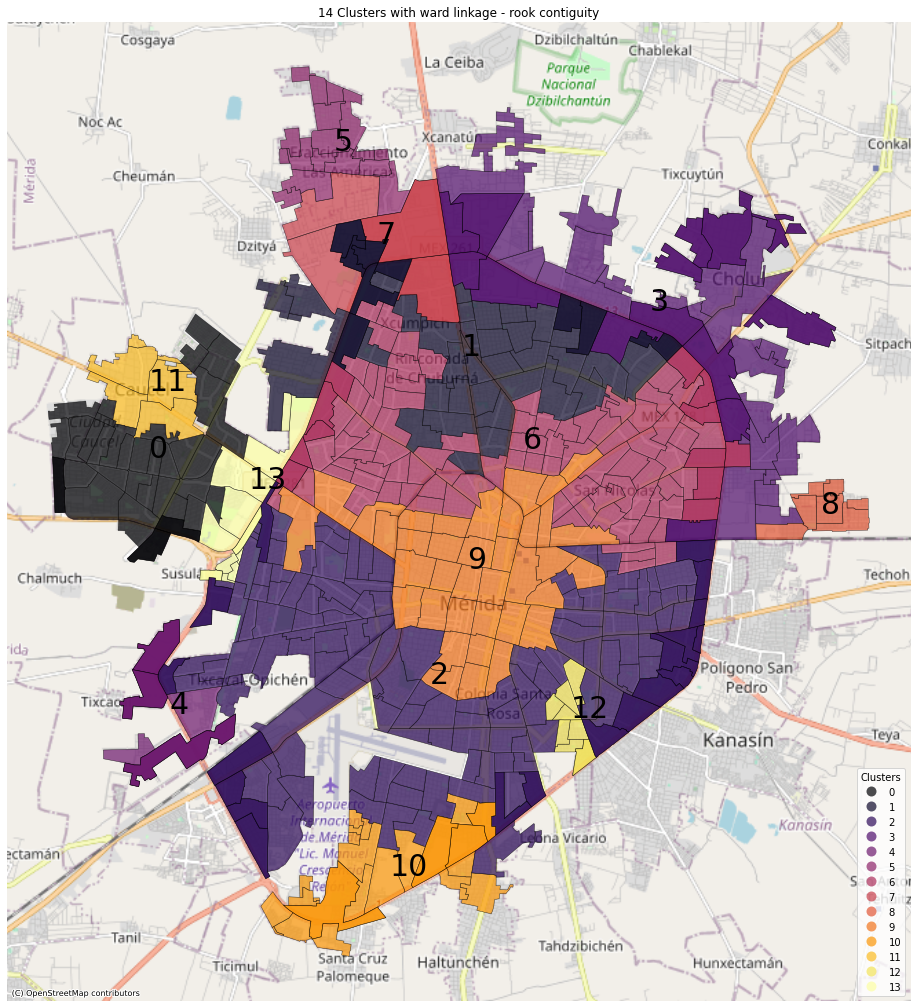

In [14]:
# connectivity matrix can be: queen_matrix or rook_matrix
con_mtx = rook_matrix

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=n, linkage=linkage, connectivity=con_mtx)
model = model.fit(X)
# add the labels of clusters to the geodataframe for plotting
data_ageb['clusters_rook'] = model.labels_

fig, ax = plt.subplots(figsize=(18, 18))

variable = 'clusters_rook'
data_ageb.plot(ax=ax, 
          column=variable, 
          cmap='inferno', 
          scheme='fisherjenks', 
          legend = True, 
          k=n, #same as the number of clusters
          edgecolor='black',
          legend_kwds={"loc": 4, "labels":list(range(0,n)), "title":"Clusters"},
          linewidth=0.5, 
          alpha=0.7)
ctx.add_basemap(ax, 
                crs=data_ageb.crs,
                source=ctx.providers.OpenStreetMap.CH
                      )
ax.set_title('{} Clusters with {} linkage - rook contiguity'.format(n, linkage))
ax.axis('off')

# dissolve by created clusters making a unary_union of the AGEBs in the same cluster
cluster_geometry = data_ageb.dissolve(by='clusters_rook')
cluster_geometry.reset_index(inplace=True)
# annotate the cluster label in the plot
for _, cluster in cluster_geometry.iterrows():
    text = cluster["clusters_rook"]
    c = cluster["geometry"].centroid
    ax.annotate(text, (c.x, c.y), c="black", fontsize=30)

save_plot(fig, ax, filepath='./clustering/{}-clusters-{}-linkage-rook.png'.format(n, linkage), dpi=300, axes=False)
plt.show()

## Queen contiguity 

Construct the "Queen" adjacency matrix. In geographical applications, the "Queen" adjacency graph considers two polygons as connected if they share a single point on their boundary. Observation: Queen neighbors have more connections than rook neighbors.

In [10]:
queen = weights.Queen.from_dataframe(data_ageb)
# generate a full numpy.ndarray
queen_matrix = queen.full()
# get the connectivity matrix
queen_matrix = queen_matrix[0]

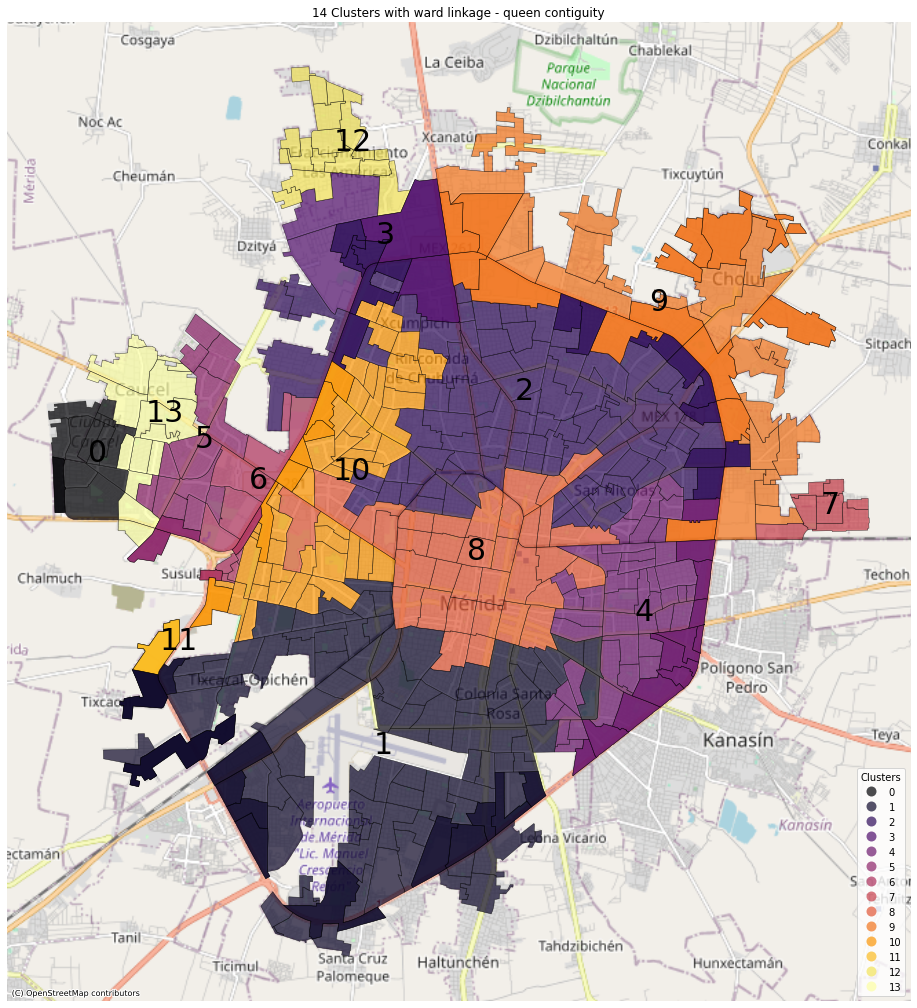

In [15]:
# connectivity matrix can be: queen_matrix or rook_matrix
con_mtx = queen_matrix

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=n, linkage=linkage, connectivity=con_mtx)
model = model.fit(X)
# add the labels of clusters to the geodataframe for plotting
data_ageb['clusters_queen'] = model.labels_

fig, ax = plt.subplots(figsize=(18, 18))

variable = 'clusters_queen'
data_ageb.plot(ax=ax, 
          column=variable, 
          cmap='inferno', 
          scheme='fisherjenks', 
          legend = True, 
          k=n, #same as the number of clusters
          edgecolor='black',
          legend_kwds={"loc": 4, "labels":list(range(0,n)), "title":"Clusters"},
          linewidth=0.5, 
          alpha=0.7)
ctx.add_basemap(ax, 
                crs=data_ageb.crs,
                source=ctx.providers.OpenStreetMap.CH
                      )
ax.set_title('{} Clusters with {} linkage - queen contiguity'.format(n, linkage))
ax.axis('off')
# dissolve by created clusters making a unary_union of the AGEBs in the same cluster
cluster_geometry = data_ageb.dissolve(by='clusters_queen')
cluster_geometry.reset_index(inplace=True)
for _, cluster in cluster_geometry.iterrows():
    text = cluster["clusters_queen"]
    c = cluster["geometry"].centroid
    ax.annotate(text, (c.x, c.y), c="black", fontsize=30)

save_plot(fig, ax, filepath='./clustering/{}-clusters-{}-linkage-queen.png'.format(n, linkage), dpi=300, axes=False)
plt.show()

In [16]:
# dissolve by clusters and aggregate the info calculating the mean
cluster_queen_data = data_ageb.dissolve(by='clusters_queen', aggfunc='mean').drop(columns=['geometry', 'clusters_rook', 'time']).applymap(lambda x: round(x, 2))
cluster_queen_data
#cluster_queen_data.reset_index(inplace=True)

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,prnk_min,prnk_min_n,radius,sloop_prop,st_dty_km,st_len_avg,st_len_tot,st_seg_cnt,st_n_avg,popdensity
clusters_queen,,,,,,,,,,,,,,,,,,,,,
0,2534.62,1295.00,1239.62,144.38,72.69,71.69,2388.92,1221.62,1167.31,2278.62,...,0.00,3.109482e+09,691.39,0.0,18108.45,84.45,8799.92,103.15,3.30,5550.62
1,2504.32,1279.32,1224.89,105.19,51.56,53.57,2395.03,1225.74,1169.29,2314.51,...,0.01,2.702137e+09,709.59,0.0,12829.09,94.23,7480.68,81.71,3.26,4819.62
2,1637.54,868.20,769.34,38.56,19.06,19.33,1595.01,847.06,747.95,1564.85,...,0.00,2.795526e+09,691.98,0.0,15406.26,87.91,7794.91,89.27,3.32,3280.93
3,2188.17,1127.67,1060.50,58.33,30.83,27.50,2129.83,1096.83,1033.00,2081.83,...,0.00,1.953083e+09,2021.93,0.0,9928.81,112.28,26623.12,244.33,2.89,942.82
4,2340.84,1218.35,1122.49,73.93,35.38,38.54,2264.00,1181.51,1082.49,2204.04,...,0.00,2.204544e+09,612.41,0.0,17212.11,80.37,6753.28,83.51,3.31,6228.21
5,2193.22,1122.78,1070.44,90.44,46.28,44.17,2101.72,1075.94,1025.78,2026.28,...,0.01,4.062294e+09,747.19,0.0,16600.11,80.76,8869.85,123.39,3.05,4238.83
6,738.69,381.31,357.38,29.92,15.62,14.31,708.69,365.62,343.08,686.92,...,0.06,2.858612e+09,536.13,0.0,8221.79,95.86,3496.31,33.38,3.13,3648.95
7,2030.71,1052.00,978.71,121.86,56.57,65.29,1908.29,995.14,913.14,1825.29,...,0.01,5.572756e+09,690.56,0.0,17514.35,76.24,7096.45,91.57,2.95,4931.94
8,1767.56,947.09,820.47,37.21,18.53,18.59,1726.50,926.62,799.88,1697.74,...,0.00,7.809190e+08,898.25,0.0,11603.14,101.87,8363.37,86.56,3.39,2484.74


In [17]:
# dissolve by clusters and aggregate the info calculating the mean
cluster_rook_data = data_ageb.dissolve(by='clusters_rook', aggfunc='mean').drop(columns=['geometry', 'clusters_queen', 'time']).applymap(lambda x: round(x, 2))
cluster_rook_data
#cluster_rook_data.reset_index(inplace=True)

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,prnk_min,prnk_min_n,radius,sloop_prop,st_dty_km,st_len_avg,st_len_tot,st_seg_cnt,st_n_avg,popdensity
clusters_rook,,,,,,,,,,,,,,,,,,,,,
0,2265.47,1162.79,1102.68,107.89,54.58,53.32,2156.21,1107.50,1048.71,2070.89,...,0.01,3.423326e+09,705.67,0.0,16435.65,81.17,8181.95,106.53,3.17,4793.26
1,1768.17,931.00,837.17,42.88,21.10,21.58,1720.27,907.27,813.00,1686.79,...,0.01,2.862480e+09,768.38,0.0,14365.00,92.45,8754.81,96.00,3.25,3071.66
2,2563.19,1322.23,1240.92,91.28,44.84,46.40,2467.97,1275.43,1192.54,2396.08,...,0.00,2.129538e+09,656.99,0.0,14962.54,88.78,7106.17,80.99,3.33,5773.95
3,978.92,504.26,474.66,34.70,16.79,17.77,924.09,477.32,446.77,896.72,...,0.01,4.525729e+09,959.12,0.0,8866.13,109.95,9156.86,86.45,2.95,1035.20
4,1488.82,749.91,732.36,86.91,43.82,43.00,1395.36,706.00,689.36,1334.27,...,0.00,4.204105e+09,732.20,0.0,7827.63,97.01,9172.84,103.91,2.93,1163.13
5,1674.12,873.59,800.53,66.35,33.47,32.88,1606.41,839.47,766.94,1551.41,...,0.01,4.147751e+09,556.72,0.0,16502.65,81.63,6144.62,75.59,3.16,4496.02
6,1837.07,969.39,867.69,45.69,22.31,23.30,1786.30,944.49,841.82,1748.88,...,0.00,2.852076e+09,626.22,0.0,17169.01,82.94,6997.43,85.00,3.35,4546.40
7,2188.17,1127.67,1060.50,58.33,30.83,27.50,2129.83,1096.83,1033.00,2081.83,...,0.00,1.953083e+09,2021.93,0.0,9928.81,112.28,26623.12,244.33,2.89,942.82
8,2030.71,1052.00,978.71,121.86,56.57,65.29,1908.29,995.14,913.14,1825.29,...,0.01,5.572756e+09,690.56,0.0,17514.35,76.24,7096.45,91.57,2.95,4931.94
